# Remote Sensing for Water Bodies

## Imports

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np


from sensingpy import reader, plot
from sensingpy.enums import SENTINEL2_BANDS
from sensingpy.preprocessing.outliers import IQR

In [2]:
import warnings

warnings.filterwarnings("ignore")

## Load Satellite Image

In [3]:
satellite = reader.open(r"D:\marine_observatory\raw\Sentinel-2\30SXG\S2C_MSI_2025_03_25_11_01_08_T30SXG_L2R.nc")
satellite.rename_by_enum(SENTINEL2_BANDS)

Bands: ['lon', 'lat', 'sza', 'vza', 'raa', 'rhot_B1', 'rhos_B1', 'rhot_B2', 'rhos_B2', 'rhot_B3', 'rhos_B3', 'rhot_B4', 'rhos_B4', 'rhot_B5', 'rhos_B5', 'rhot_B6', 'rhos_B6', 'rhot_B7', 'rhos_B7', 'rhot_B8', 'rhos_B8', 'rhot_B8A', 'rhos_B8A', 'rhot_B9', 'rhot_B10', 'rhot_B11', 'rhos_B11', 'rhot_B12', 'rhos_B12'] | Height: 10980 | Width: 10980

In [4]:
mmm = gpd.read_file(r'D:\batimetria\scripts\areas\mmn.json').to_crs(satellite.crs).geometry

satellite.clip(mmm)

Bands: ['lon', 'lat', 'sza', 'vza', 'raa', 'rhot_B1', 'rhos_B1', 'rhot_B2', 'rhos_B2', 'rhot_B3', 'rhos_B3', 'rhot_B4', 'rhos_B4', 'rhot_B5', 'rhos_B5', 'rhot_B6', 'rhos_B6', 'rhot_B7', 'rhos_B7', 'rhot_B8', 'rhos_B8', 'rhot_B8A', 'rhos_B8A', 'rhot_B9', 'rhot_B10', 'rhot_B11', 'rhos_B11', 'rhot_B12', 'rhos_B12'] | Height: 2477 | Width: 2122

## RGB

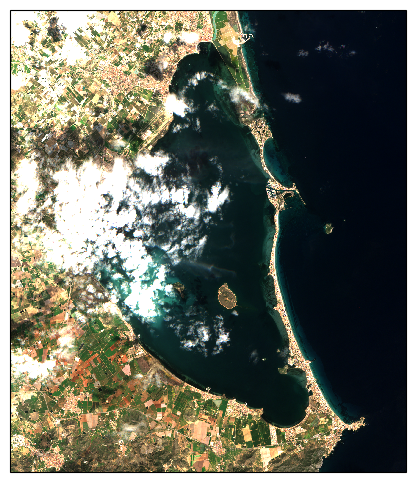

In [5]:
fig, ax = plot.get_geofigure(satellite.crs, 1, 1)
ax = plot.plot_rgb(satellite, 'rhos_B4', 'rhos_B3', 'rhos_B2', ax = ax, brightness = 5)

## False Color (Vegetation)

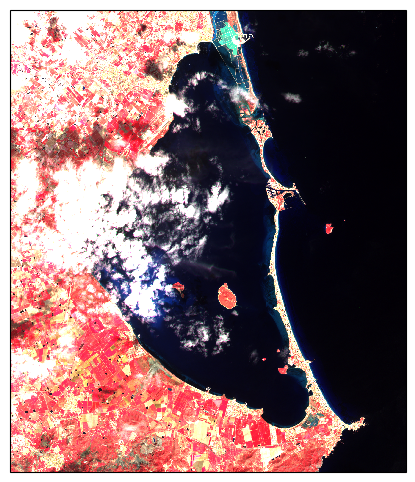

In [6]:
fig, ax = plot.get_geofigure(satellite.crs, 1, 1)
ax = plot.plot_rgb(satellite, 'rhos_B8', 'rhos_B4', 'rhos_B3', ax = ax, brightness = 5)

## Water Index (NDWI)

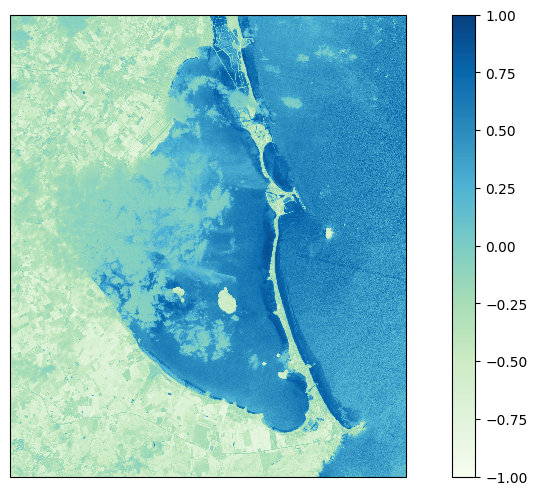

In [ ]:
satellite.add_band('NDWI', IQR(satellite.normalized_diference('rhos_B3', 'rhos_B8')))


fig, ax = plot.get_geofigure(satellite.crs, 1, 1)
ax, mappable = plot.plot_band(satellite, 'NDWI', ax = ax, vmin = -1, vmax = 1, cmap = 'GnBu')
fig.colorbar(mappable)

## Mask Land using SWIR 1 band

In [8]:
satellite.mask(satellite.select('rhot_B11') < 0.1)

Bands: ['lon', 'lat', 'sza', 'vza', 'raa', 'rhot_B1', 'rhos_B1', 'rhot_B2', 'rhos_B2', 'rhot_B3', 'rhos_B3', 'rhot_B4', 'rhos_B4', 'rhot_B5', 'rhos_B5', 'rhot_B6', 'rhos_B6', 'rhot_B7', 'rhos_B7', 'rhot_B8', 'rhos_B8', 'rhot_B8A', 'rhos_B8A', 'rhot_B9', 'rhot_B10', 'rhot_B11', 'rhos_B11', 'rhot_B12', 'rhos_B12', 'NDWI'] | Height: 2477 | Width: 2122

## Transform Water Surface Reflectance to Rrs (Water Leaving)

In [10]:
for band in [band for band in satellite.band_names if 'rhos' in band]:
    satellite.add_band(band.replace('rhos', 'Rrs'), satellite.select(band) / np.pi)

## Spectral analysis

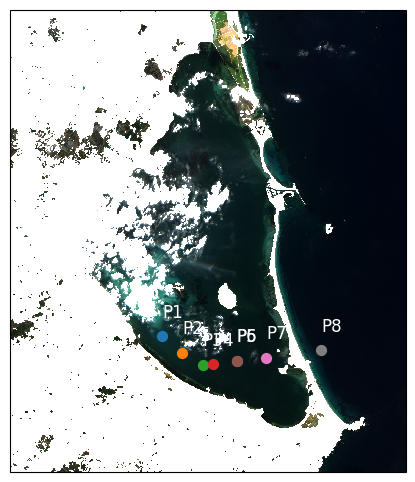

In [17]:
points = gpd.read_file(r"D:\batimetria\scripts\areas\mmn_points\mmn_points.shp").to_crs(satellite.crs).geometry.iloc[4::2]


fig, ax = plot.get_geofigure(satellite.crs, 1, 1, figsize = (24, 6))
ax = plot.plot_rgb(satellite, 'rhos_B4', 'rhos_B3', 'rhos_B2', ax = ax, brightness = 5)

for idx, point in enumerate(points):
    ax.scatter(point.x, point.y, s = 50, label = f'P{idx + 1}')
    ax.text(point.x, point.y + 1000, f'P{idx + 1}', fontsize = 12, color = 'white')

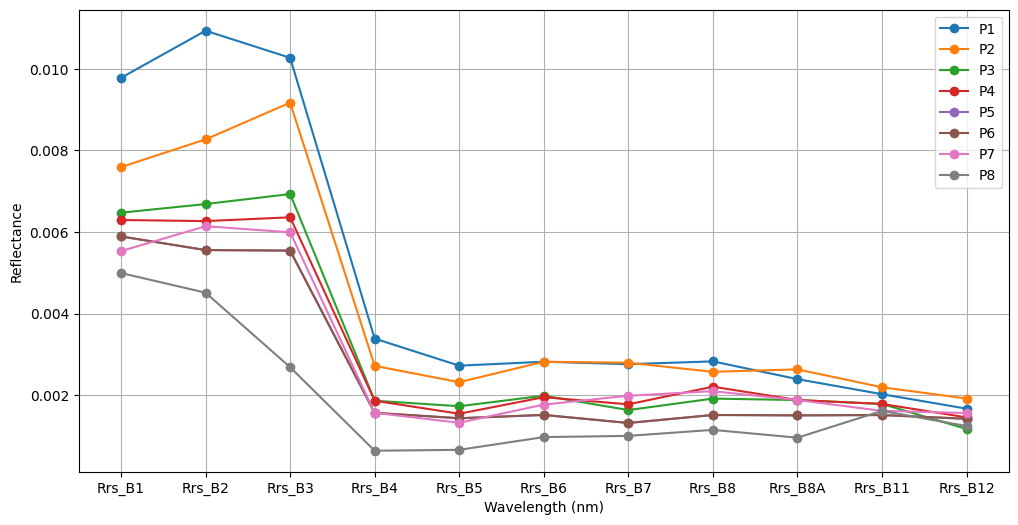

In [18]:
bands = [band for band in satellite.band_names if 'Rrs' in band]
spectral = satellite.extract_values(points.x.values, points.y.values, bands = bands, is_1D = True)

fig, ax = plt.subplots(1, 1, figsize = (12, 6))
for i in range(len(points)):
    ax.plot(bands, spectral[:, i], '-o', label = f'P{i + 1}')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Reflectance')
ax.legend()
ax.grid()